Import Data
---

In [1]:
import pandas as pd # Loadind Data

#df = pd.read_csv("DataBase_Draft_2_18_2020.csv")
df = pd.read_csv("DataBase_Draft_3_23_2020.csv")
df.shape
df.head()
list(df)

['ID',
 'GroupNum',
 'Height',
 'Weight',
 'Age',
 'Male',
 'RightLeg',
 'AdaptationDuration',
 'Abrupt',
 'MidSpeed',
 'SpeedRatio',
 'SpeedDifference',
 'SelfSelected',
 'FDBK',
 'TMBase',
 'SlowBase',
 'FastBase',
 'MidBase',
 'EarlyA',
 'TMSteady',
 'TMAfter',
 'OGBase',
 'OGAfter',
 'IsCatch',
 'Stroke',
 'TextSpeedRatio']

Data Checking
---

In [2]:
import matplotlib.pyplot as plt  # To visualize
import math #rounding up

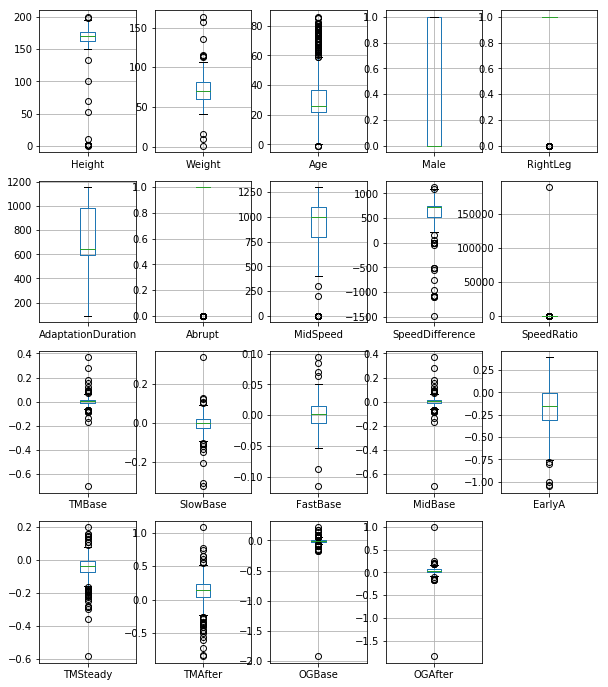

In [3]:
Measures2Check=["Height", "Weight", "Age", "Male", "RightLeg", "AdaptationDuration",\
               "Abrupt", "MidSpeed", "SpeedDifference", "SpeedRatio", \
               "TMBase", "SlowBase", "FastBase", "MidBase", "EarlyA",\
               "TMSteady", "TMAfter", "OGBase", "OGAfter"]


def CheckingBoxWhiskers(Inputs='Height'):
    nrows=math.ceil(len(Inputs)/5)
    plt.figure(figsize=(10, 12))
    for i in range(len(Inputs)):
        plt.subplot(nrows, 5, i+1)
        hist = df.boxplot(column=Inputs[i])
    plt.show()
    
CheckingBoxWhiskers(Measures2Check)  

Data Cleaning
---

We know from previous notebook that there are issues with some of the data.  I am going to create a clean copy of the data file to work with

In [4]:
import pandas as pd
import numpy as np # Data cleaning and manipulaitons

In [5]:
# Make a COPY of my data for cleaning
dfClean=df.copy()

In [6]:
# I don't want to drop all rows with NaNs because there are experiemental reasons why there may be Nans
# So here is a better means to get rid of rows that are missing 'essential' data
badIndex=(np.isnan(df.TMSteady)) | (np.isnan(df.SpeedDifference)) | (np.isnan(df.SpeedRatio)) |\
(np.isnan(df.EarlyA)) | (np.isnan(df.MidBase)) | (np.isnan(df.Age)) |\
(np.isnan(df.AdaptationDuration)) | (abs(df.SpeedRatio)>3)

dfClean = dfClean.drop(dfClean[badIndex].index)

dfClean.shape

(487, 26)

Note to self -- Who are these people with missing data, can I recover this data?

In [7]:
df.loc[badIndex, "ID"]

75       C0007
83       C0016
136     GYAA04
258    NimC002
266    NimG001
274     P0011_
281    NimG006
287    NimG013
288    NimG014
289    NimG015
290    NimG016
291    NimG017
428      PAL20
448      PCL20
450       PP01
451       PP02
Name: ID, dtype: object

Due to data collection difference some of these measures may have the wrong "sign" so I will correct that here.

In [8]:
dfClean["SpeedDifference"]=abs(dfClean["SpeedDifference"])
dfClean["SpeedRatio"]=abs(dfClean["SpeedRatio"])
dfClean["MidSpeed"]=abs(dfClean["MidSpeed"])

Some people have the wrong dates/birthdays...

In [9]:
df.loc[df.Age<18, "ID"]

1       B002
11      K001
129    GCY10
430    PAL22
461     PP19
Name: ID, dtype: object

In [10]:
df.loc[abs(df.SpeedRatio)>3, "ID"]

266    NimG001
287    NimG013
289    NimG015
290    NimG016
291    NimG017
Name: ID, dtype: object

Feature Engineering:
---
Might consider making some interaction terms at some point?

Make a column with BMI

In [11]:
# Convert Heights in meters to centimeters for consistency
MeterHeight = dfClean.loc[dfClean["Height"]<2,'Height'].index
dfClean.at[MeterHeight,'Height'] = 100 * dfClean.loc[dfClean["Height"]<2, "Height"]

# Calculate what the mean resonable weight is
NormalHeight = dfClean.loc[dfClean["Height"]>122,'Height'].index
NormalHeightMean = dfClean.loc[NormalHeight,'Height'].mean()

# Replace unresonable weights with the mean
WrongHeight = dfClean.loc[dfClean["Height"]<122,'Height'].index
dfClean.at[WrongHeight,'Height'] = NormalHeightMean

dfClean["Height"].describe()

count    487.000000
mean     171.016985
std        9.025584
min      132.500000
25%      164.000000
50%      171.500000
75%      177.000000
max      200.000000
Name: Height, dtype: float64

In [12]:
# Convert confirmed weights in pounds to killograms
dfClean.at[dfClean["ID"]=="CG09_NewProKin", "Weight"]=61.7
dfClean.at[dfClean["ID"]=="Forget17", "Weight"]=71.2

In [13]:
# Finally, calculate BMI
dfClean["BMI"] = (dfClean["Weight"]/(dfClean["Height"]/100)**2)
dfClean.loc[dfClean["BMI"]>40, ["ID", "Height", "Weight", "BMI"]]

,ID,Height,Weight,BMI
52,BSN02_NewProKin,162.2,114.0,43.331443
331,OG94,183.5,163.4,48.526606


The BMI is still very high for some of the subjects, but these are consistent with self reported heights and weights.

Feature Engineering: Discretize Age ... Anything Else?
---

In [14]:
dfClean["Young"]=1*(dfClean["Age"]<40)

Feature Engineering: Discretize TMSteady States
---

Okay, so Rayid suggested that I discretize the steady states for now to make my interpretation of the ML analysis easier.  Given that we know 0.04 is a clinically signfiicant step length asymmetry threshold and that this roughly corresponds to the 50% percentile of steady states (see below) I am using this a somewhat arbitrary threshold for "good" vs. "bad" steady states.

In other words  I am framining this as a classification problem.  Specifically, I am classifying those that get basically to symmetric stepping or overshot symmetry (which would be energetically optimal, but this level of optimization is usually not possible for the duration of a single session).

In [15]:
dfClean["TMSteady"].describe()

count    487.000000
mean      -0.046913
std        0.067847
min       -0.586560
25%       -0.071981
50%       -0.037420
75%       -0.009766
max        0.158950
Name: TMSteady, dtype: float64

In [16]:
dfClean["TMSteadyGood"]=1*(dfClean["TMSteady"]> -0.04)
import seaborn as sns # Also to visualize
sns.countplot(x="TMSteadyGood", data=dfClean)

In [17]:
dfClean["TMAfter"].describe()

count    478.000000
mean       0.136540
std        0.195453
min       -0.848090
25%        0.057481
50%        0.149200
75%        0.235272
max        1.081200
Name: TMAfter, dtype: float64

In [18]:
dfClean["TMAfterGood"]=1*(dfClean["TMAfter"]> 0.04)
sns.countplot(x="TMAfterGood", data=dfClean)

There are more people who have a good "TMAfterGood", but it is so unbalanced that I should use over-sampling (i.e., SMOTE -- Synthetic Minority Oversampling Technique)?

Presumably I will want to save the cleaned data....
---

In [19]:
dfClean["SpeedRatio"].describe()

count    487.000000
mean       2.139630
std        0.489615
min        0.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: SpeedRatio, dtype: float64

In [20]:
dfClean.to_csv('CleanDataBase.csv', index=False)